In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

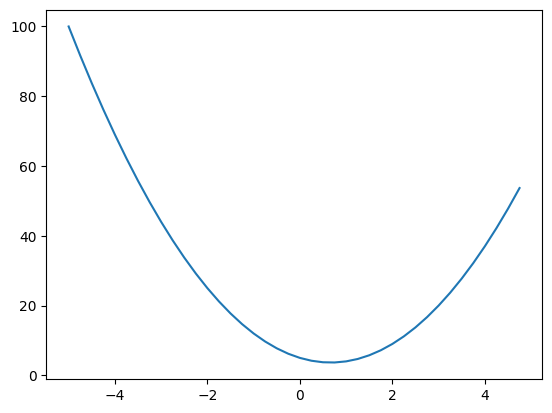

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000000001
x = -3.0
(f(x + h) - f(x)) / h


-21.999824184604222

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
    def __init__(self, data, _children = (), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data},label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * res.grad
            other.grad += 1.0 * res.grad

        res._backward = _backward
        return res

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        res = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * res.grad
            other.grad += self.data * res.grad

        res._backward = _backward
        return res
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        res = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * res.grad
        
        res._backward = _backward
        return res

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

        res = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * res.grad

        res._backward = _backward
        return res
    
    def exp(self):
        x = self.data
        res = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += res.data * res.grad

        res._backward = _backward
        return res

    def backward(self):
        topo = []
        visited = set()

        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)

        topological_sort(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L' 
d

a = Value(2.0, label='a')
a.exp()

a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0,label=)

In [9]:
d._prev

{Value(data=-6.0,label=e), Value(data=10.0,label=c)}

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if the value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


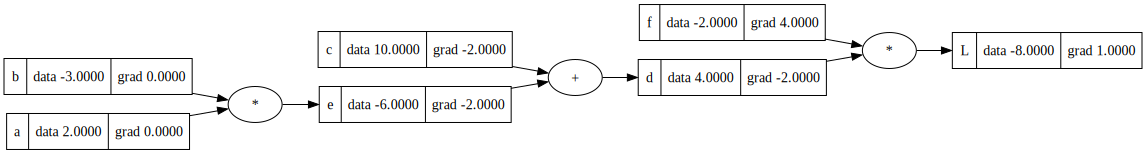

In [12]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

draw_dot(L)

L = d * f

dL/dd = f
dL/df = d

(f(x+h) - f(x)) / h

((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f)/h
f

dL/dc = ?

dd/dc = 1.0
dd/de = 1.0
d = c + e

In [13]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L =d*f

print(L.data)


-35.549696


In [14]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L' 
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L' 
    L2 = L.data

    print((L2-L1)/h)

lol()

6.000000000021544


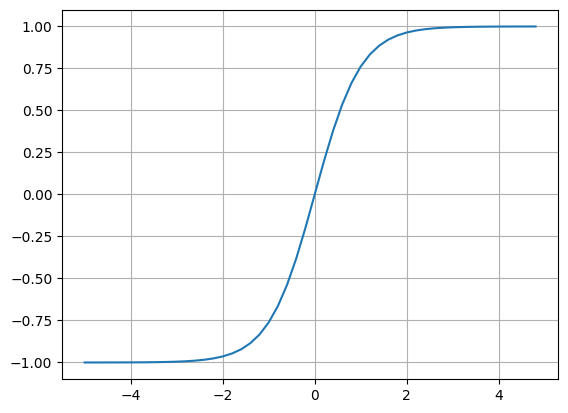

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.20))); plt.grid();

In [16]:
# Neuron math model
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# cell body raw activation n
n

# output, tanh is an activation function
o = n.tanh(); o.label = 'o'
o

Value(data=0.7071067811865476,label=o)

In [17]:
# backpropagation - fill all the gradients
o.backward()

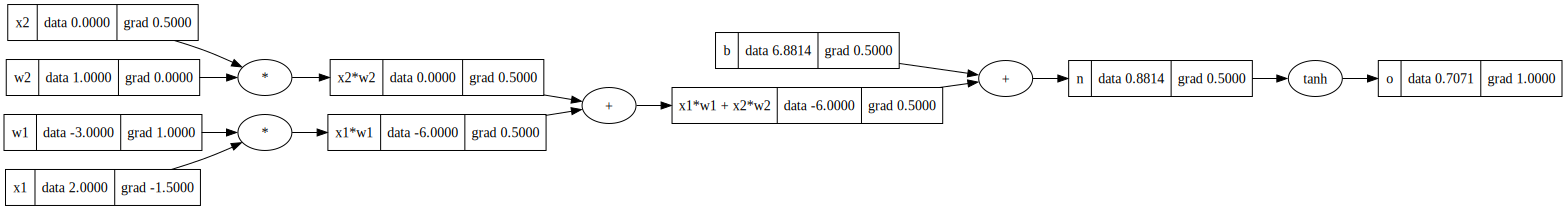

In [18]:
draw_dot(o)

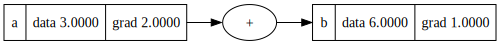

In [19]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

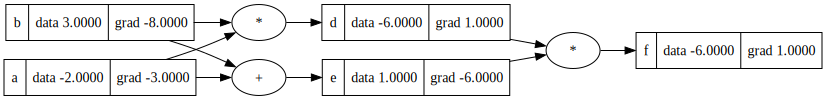

In [20]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'

f.backward()

draw_dot(f)

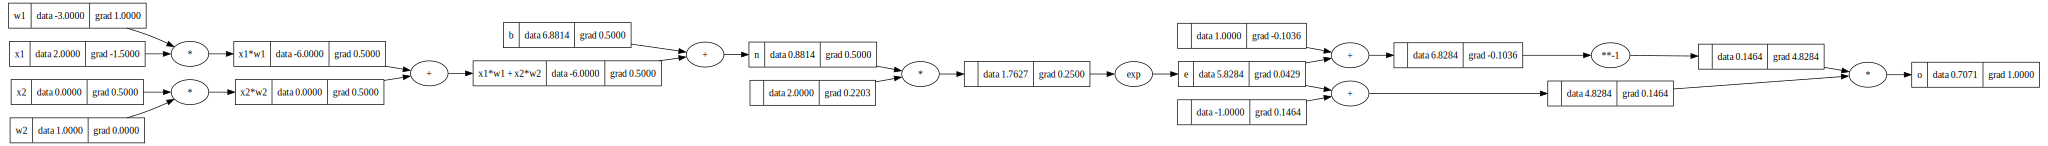

In [21]:
# Neuron math model
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# cell body raw activation n
n

# output, tanh is an activation function defined as (e**2x - 1) / (e**2x + 1)
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()


draw_dot(o)

In [22]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item()) 
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [32]:
import random

class Neuron:
    # nin - number of inputs
    def __init__(self, nin):
        self.w  = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        res = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return res

class Layer:
    # nout - number of outputs
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

# MLP is multi-layer perceptron
class MLP:
    # nouts is a list 
    def __init__(self, nin, nouts):
        # sizes of layers
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=1.9368532751236713,label=)

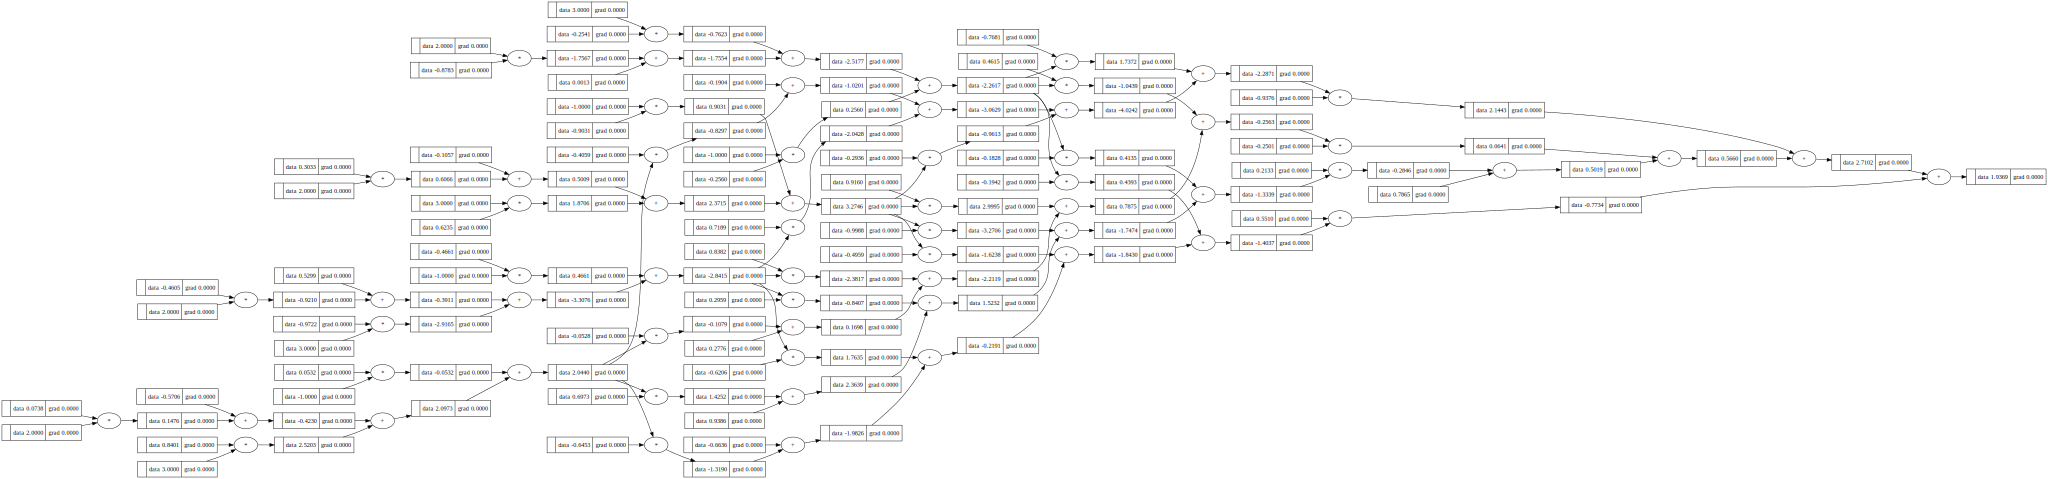

In [33]:
draw_dot(n(x))